# CosmoDC

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **nz_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/jaimerzpP/pacc) for sacc files.

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp
import sacc
import yaml
import scipy
import nz_prior as nzp

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18

In [2]:
method = "bpz"
source_0 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/shear_0.npz")
source_1 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/shear_1.npz")
source_2 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/shear_2.npz")
source_3 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/shear_3.npz")
source_4 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/shear_4.npz")
lens_0 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/lens_0.npz")
lens_1 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/lens_1.npz")
lens_2 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/lens_2.npz")
lens_3 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/lens_3.npz")
lens_4 = np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{method}/lens_4.npz")


### Load Data

In [3]:
# Sacc file
s = sacc.Sacc.load_fits("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y = yaml.load(open("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'source_4': source_4,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4}

crosscorrs_method = "BinWise"

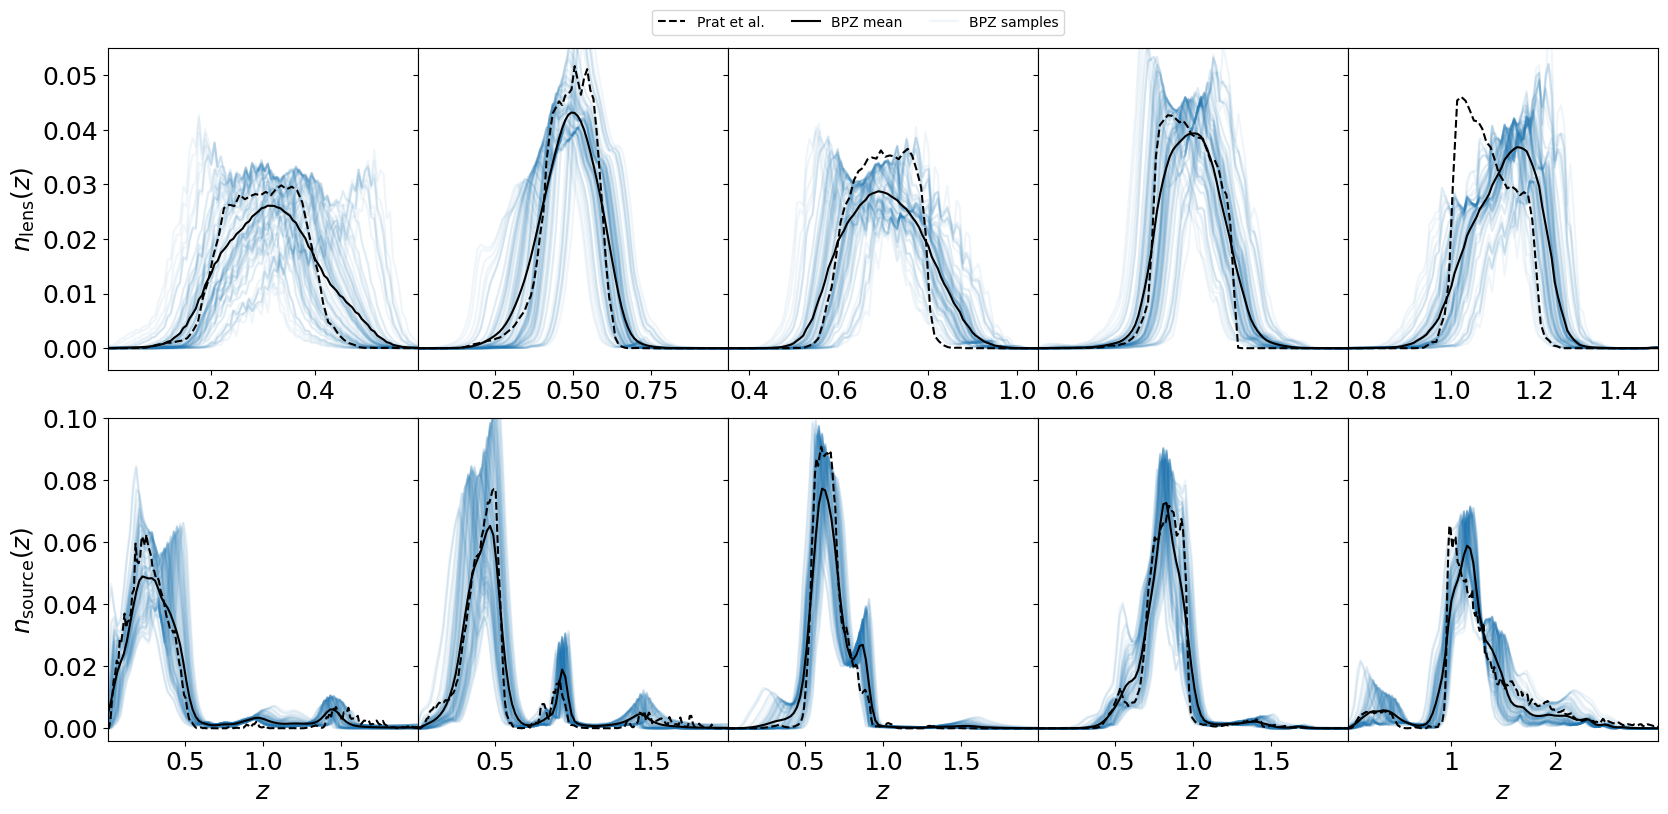

In [4]:
figure, axis = plt.subplots(2, 5, figsize=(5*4, 9))
figure.subplots_adjust(wspace=0, hspace=0.15)

#colors = ['limegreen', 'forestgreen', 'darkgreen', 'olive', 'orange']
lens_keys = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'] 
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    line3 = axis[0, i].plot(tomo['znodes'], tomo['photo_hists'][:, :100]/norm, '-', color='C0', alpha=0.07)
    line1, = axis[0, i].plot(spec.z, alpha*spec.nz, 'k--')
    line2, = axis[0, i].plot(tomo['znodes'], np.mean(tomo['photo_hists'], axis=1)/norm, 'k-')
    #axis[0].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    #axis[0, i].set_title(source_labels[i], y=0.8)
    axis[0, i].set_ylim([-0.004, 0.055])
    axis[0, i].set_xlim([tomo['znodes'][0], tomo['znodes'][-1]])
    if i == 0:
        axis[0, i].set_ylabel(r'$n_{\rm lens}(z)$')
    else:
        axis[0, i].set_yticklabels([])

#colors = ['skyblue', 'teal', 'blue', 'purple', 'darkviolet']
lens_keys = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))

    axis[1, i].plot(tomo['znodes'], tomo['photo_hists'][:, :100]/norm, '-', color='C0', alpha=0.07)
    axis[1, i].plot(spec.z, alpha*spec.nz, 'k--')
    axis[1, i].plot(tomo['znodes'], np.mean(tomo['photo_hists'], axis=1)/norm, 'k-')
    #axis[1].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    #axis[1, i].set_title(lens_labels[i], y=0.8)
    axis[1, i].set_ylim([-0.004, 0.1])
    axis[1, i].set_xlim([tomo['znodes'][0], tomo['znodes'][-1]])
    axis[1, i].set_xlabel(r'$z$')
    if i == 0:
        axis[1, i].set_ylabel(r'$n_{\rm source}(z)$')
    else:
        axis[1, i].set_yticklabels([])

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")
lines = [line1, line2, line3[0]]
labels = ["Prat et al.", "BPZ mean", "BPZ samples"]
figure.legend(lines, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.5, 0.93))
plt.show()
figure.savefig(f"/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/nzs_{method}.pdf")

In [5]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tomo = tracers_dict[key]
        nzs = tomo['photo_hists']
        zs = tomo['znodes']
        norms = np.sum(nzs, axis=0)
        axis[0,i].plot(zs, nzs/norms, 'k-', alpha=0.005)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.001, 0.1])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$n_{\rm lens}(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')
        if i > 0:
            axis[1,i].set_yticklabels([])

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

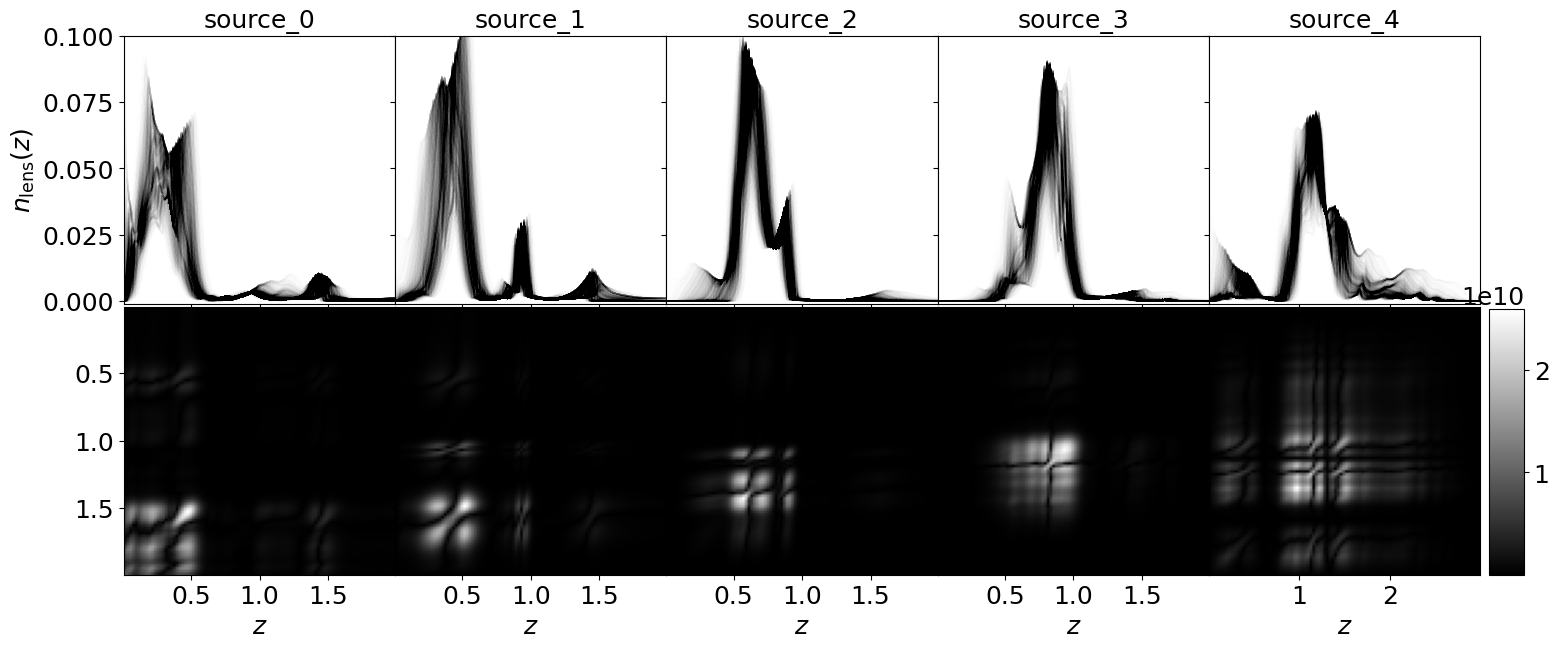

In [6]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(tomos, plot_tracers)

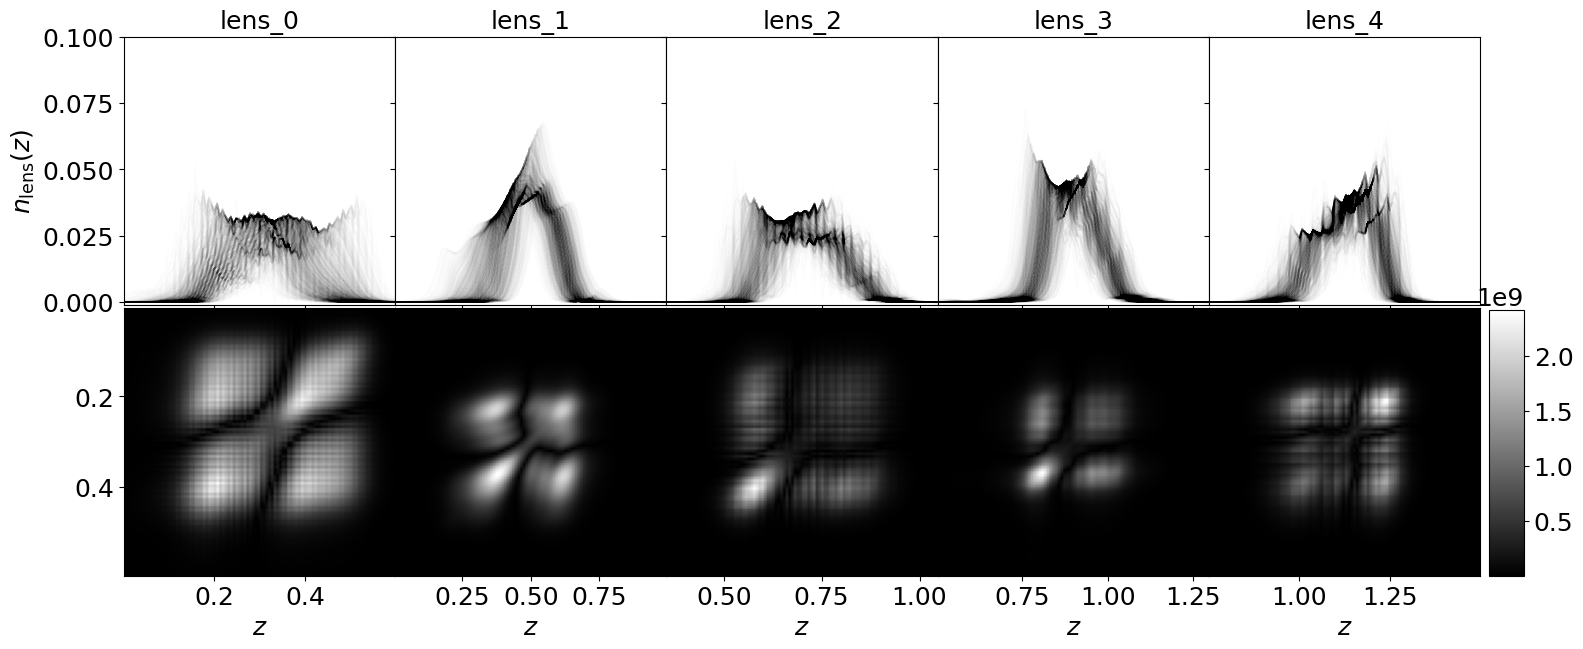

In [7]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(tomos, plot_tracers)

# Interfacing SACC and QP

In [8]:
def make_qp(ens):
    pzs = ens['photo_hists'].T
    zs_edges = ens['zgrid']
    return qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        ens = enss[key]
        q = make_qp(ens)
        ss.add_tracer('Qpnz', key, q)
    return ss

ss_qp = update_sacc_qp(s, tomos)

# Computing Uncertainties

Now we are just going to apply the methods of nz_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

In [9]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        zs, nzs = tracers_dict[key]
        nzs = nzs.T
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        #axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        axis[0,i].set_ylim([-0.001, 0.1])
        if i == 0:
            axis[0,i].set_ylabel(r'$n(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

## Shifts

In [10]:
shifts_priors = nzp.PriorSacc(ss_qp, 
                            model="Shifts",
                            compute_crosscorrs=crosscorrs_method)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [11]:
labels = [
    r"\Delta z^{\rm source \, 0}",
    r"\Delta z^{\rm source \, 1}",
    r"\Delta z^{\rm source \, 2}",
    r"\Delta z^{\rm source \, 3}",
    r"\Delta z^{\rm source \, 4}",
    r"\Delta z^{\rm lens \, 0}",
    r"\Delta z^{\rm lens \, 1}",
    r"\Delta z^{\rm lens \, 2}",
    r"\Delta z^{\rm lens \, 3}",
    r"\Delta z^{\rm lens \, 4}"]

Removed no burn in
Removed no burn in


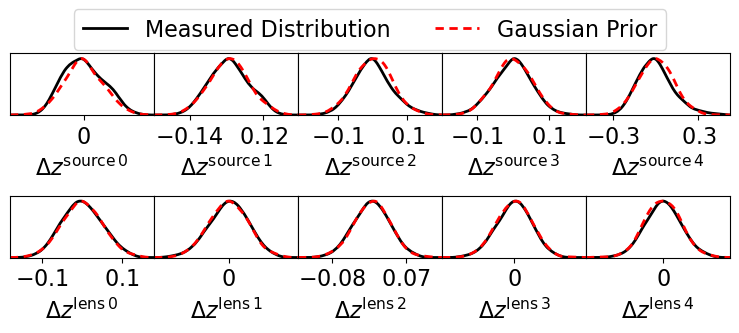

In [12]:
g = shifts_priors.plot_prior(mode="1D", add_prior=True, labels=labels, nx=5, legend_ncol=2, lws=2, ls=['-','--'])
g.export(f"/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/shifts_prior.pdf")

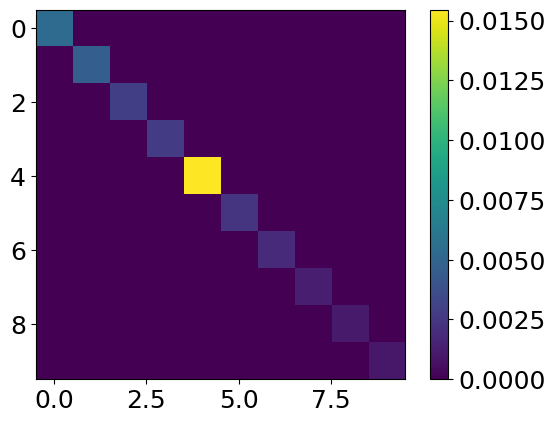

In [13]:
mean, cov, chol = shifts_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(cov)
plt.colorbar()

In [14]:
model_objs = shifts_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, cov, chol = model_obj.get_prior()
    file_name = f"dz_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_dz_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, cov=cov, chol=chol)

In [15]:
shifted_nzs = {}
for i in range(2000):
    prior_sample = shifts_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        z = model_obj.z
        nz =  model_obj.nz_mean
        param_names = model_obj.get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        s = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_and_width_model(z, nz, s[0], 1)
        if i == 0:
            shifted_nzs[tracer_name] = [z, shifted_nz]
        else:

            shifted_nzs[tracer_name] = [z, np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]


In [16]:
_shifted_nzs = {}
for i in range(2000):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        z = model_obj.z
        nz = model_obj.nz_mean
        param_names = model_obj.get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        s = model_obj.get_params()[0][i]
        shifted_nz = nzp.shift_and_width_model(z, nz, s, 1)
        if i == 0:
            _shifted_nzs[tracer_name] = [z, shifted_nz]
        else:

            _shifted_nzs[tracer_name] = [z, np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]

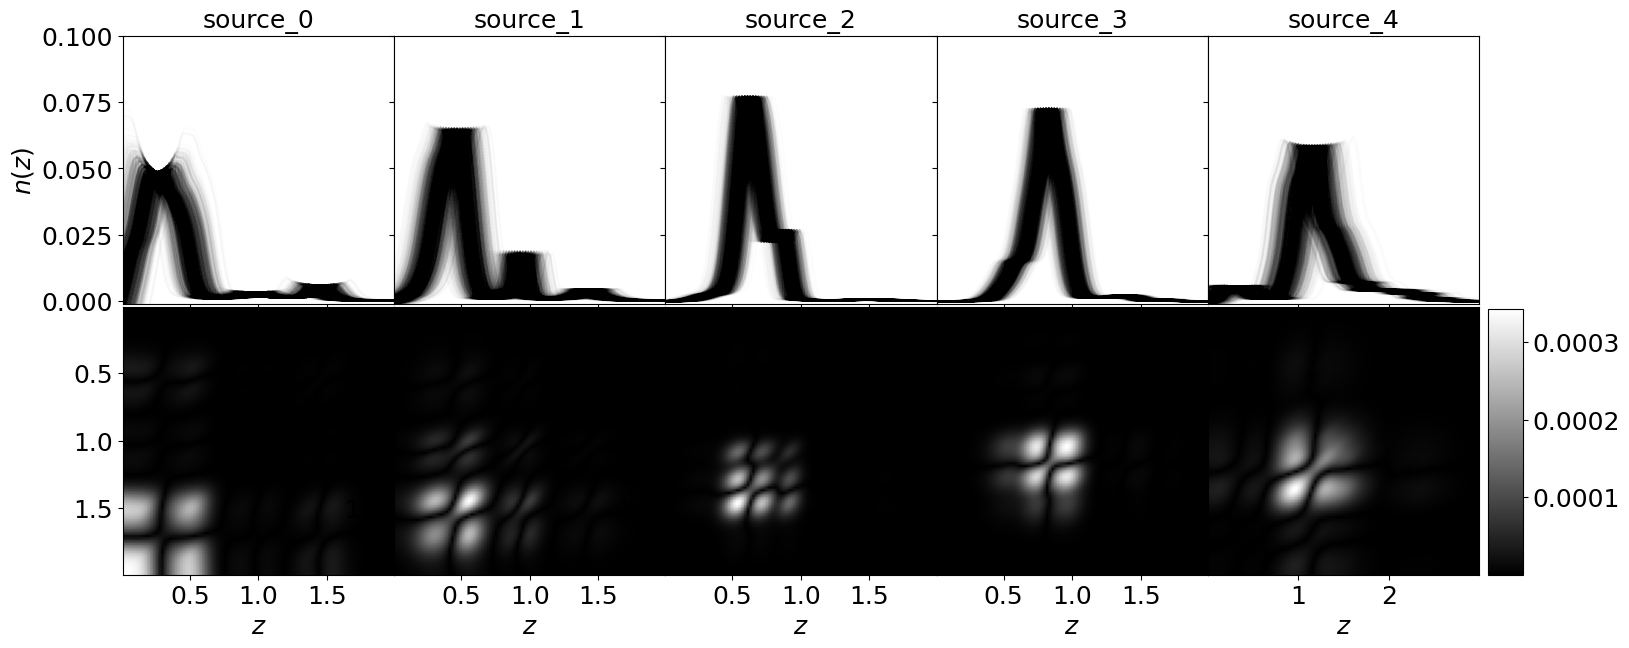

In [17]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(shifted_nzs, plot_tracers)

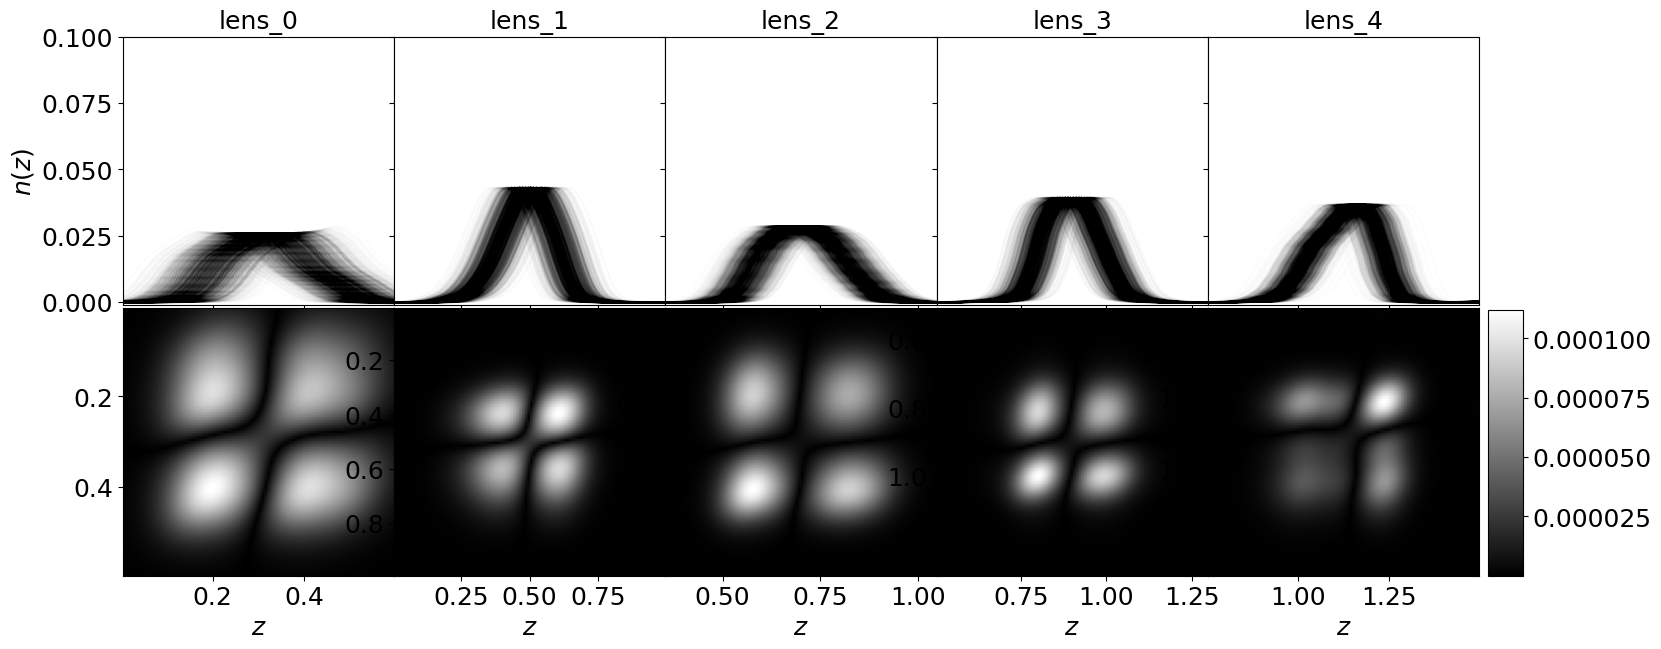

In [18]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(shifted_nzs, plot_tracers)

In [19]:
shifts_var_comp = {}
_shifts_var_comp = {}
shifts_skew_comp = {}
_shifts_skew_comp = {}
shifts_kurt_comp = {}
_shifts_kurt_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        shifted_nzs_i = shifted_nzs[tracer_name][1].T
        _shifted_nzs_i = _shifted_nzs[tracer_name][1].T
        nzs = model_obj.nzs
        zs = model_obj.z
        cov = np.cov(shifted_nzs_i)
        _cov = np.cov(_shifted_nzs_i)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        sk = scipy.stats.skew(shifted_nzs_i, axis=1)
        _sk = scipy.stats.skew(_shifted_nzs_i, axis=1)
        __sk = scipy.stats.skew(nzs, axis=0)
        ku = scipy.stats.kurtosis(shifted_nzs_i, axis=1)
        _ku = scipy.stats.kurtosis(_shifted_nzs_i, axis=1)
        __ku = scipy.stats.kurtosis(nzs)
        print(tracer_name, np.mean(errs), np.mean(_errs), np.mean(__errs))
        print(tracer_name, np.mean(sk), np.mean(_sk), np.mean(__sk))
        print(tracer_name, np.mean(ku), np.mean(_ku), np.mean(__ku))
        print("=====")
        shifts_var_comp[tracer_name]   = [zs, (errs-__errs)/__errs]
        _shifts_var_comp[tracer_name]  = [zs, (_errs-__errs)/__errs]
        shifts_skew_comp[tracer_name]  = [zs, (sk-__sk)/__sk]
        _shifts_skew_comp[tracer_name] = [zs, (_sk-__sk)/__sk]
        shifts_kurt_comp[tracer_name]  = [zs, (ku-__ku)/__ku]
        _shifts_kurt_comp[tracer_name] = [zs, (_ku-__ku)/__ku]


source_0 0.00426395568814567 0.004264083615897972 0.004203544467801479
source_0 2.141579777842956 2.1417821190079223 1.089871935162711
source_0 20.930032542420527 20.93675688973632 2.976247856472152
=====
source_1 0.00567910433824547 0.005679235853598204 0.005915508482667201
source_1 1.901260285872912 1.9010963217775239 1.951176083612043
source_1 11.50306182065357 11.505033983133988 11.418885104639767
=====
source_2 0.00435492631025271 0.004355090764365523 0.0038540940899966436
source_2 1.897307092660247 1.897187296706284 3.1801783128477465
source_2 23.826992070229302 23.832028810638693 52.538439103022085
=====
source_3 0.0038263047514238697 0.0038264790712190656 0.003826968983939829
source_3 1.853954188683393 1.853963129823214 4.181483337161585
source_3 12.520142575139174 12.522636996793818 67.10002905978006
=====
source_4 0.004862841051646687 0.004863035274273005 0.00394747346337585
source_4 1.502141921493685 1.5016996934866895 3.283442142074541
source_4 12.785277135542426 12.7851914

## Shifts & widths

In [20]:
SnWs_priors = nzp.PriorSacc(ss_qp, 
                            model="ShiftsWidths",
                            compute_crosscorrs=crosscorrs_method)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [21]:
labels = np.array([
    r"\Delta z^{\rm source \, 0}",
    r"w_z^{\rm source \, 0}",
    r"\Delta z^{\rm source \, 1}",
    r"w_z^{\rm source \, 1}",
    r"\Delta z^{\rm source \, 2}",
    r"w_z^{\rm source \, 2}",
    r"\Delta z^{\rm source \, 3}",
    r"w_z^{\rm source \, 3}",
    r"\Delta z^{\rm source \, 4}",
    r"w_z^{\rm source \, 4}",
    r"\Delta z^{\rm lens \, 0}",
    r"w_z^{\rm lens \, 0}",
    r"\Delta z^{\rm lens \, 1}",
    r"w_z^{\rm lens \, 1}",
    r"\Delta z^{\rm lens \, 2}",
    r"w_z^{\rm lens \, 2}",
    r"\Delta z^{\rm lens \, 3}",
    r"w_z^{\rm lens \, 3}",
    r"\Delta z^{\rm lens \, 4}",
    r"w_z^{\rm lens \, 4}"
])

In [22]:
order = [0, 2, 4, 6, 8, 1, 3, 5, 7, 9,
        10, 12, 14, 16, 18, 11, 13, 15, 17, 19]

Order:  [0, 2, 4, 6, 8, 1, 3, 5, 7, 9, 10, 12, 14, 16, 18, 11, 13, 15, 17, 19]
Removed no burn in
Removed no burn in


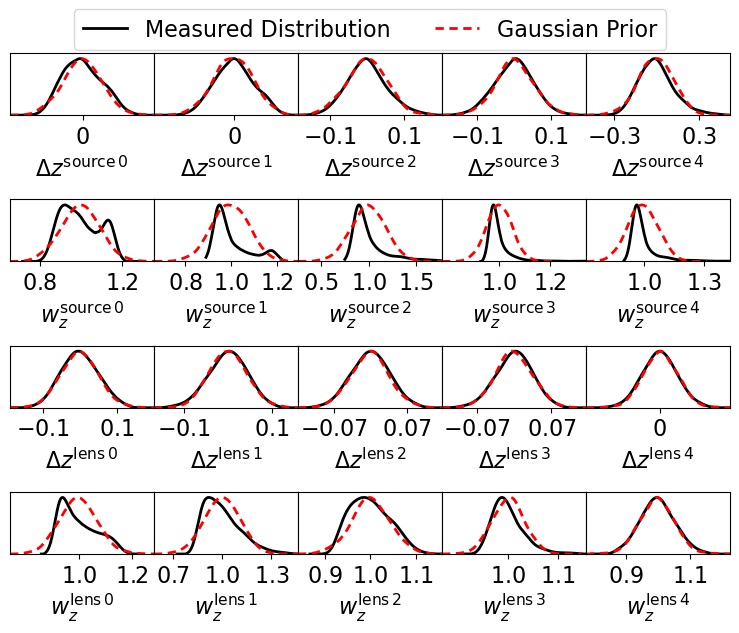

In [23]:
g = SnWs_priors.plot_prior(
    order=order,
    labels=labels, 
    mode="1D", 
    nx=5, 
    legend_ncol=2, 
    lws=2, 
    ls=['-','--'])
g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/SnWs_prior.pdf")

In [24]:
model_objs = SnWs_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, cov, chol = model_obj.get_prior()
    file_name = f"wzdz_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_wzdz_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, cov=cov, chol=chol)

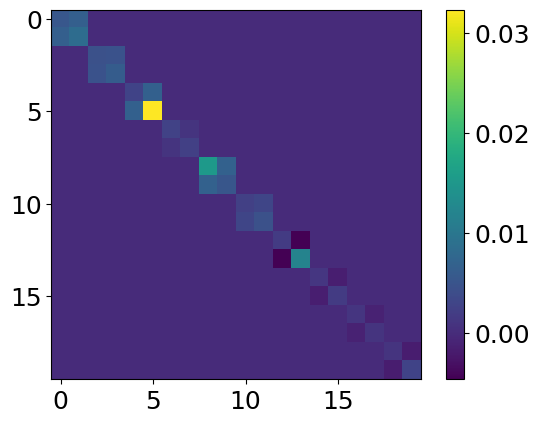

In [25]:
mean, cov, chol = SnWs_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(cov)
plt.colorbar();

In [26]:
SnWs_nzs = {}
for i in range(2000):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        z = model_obj.z
        nz = model_obj.nz_mean
        param_names = model_obj.get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        s, w = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_and_width_model(z, nz, s, w)
        if i == 0:
            SnWs_nzs[tracer_name] = [z, shifted_nz]
        else:

            SnWs_nzs[tracer_name] = [z, np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]

In [27]:
_SnWs_nzs = {}
for i in range(2000):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        z = model_obj.z
        nz = model_obj.nz_mean
        param_names = model_obj.get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        s, w = model_obj.get_params().T[i]
        shifted_nz = nzp.shift_and_width_model(z, nz, s, w)
        if i == 0:
            _SnWs_nzs[tracer_name] = [z, shifted_nz]
        else:

            _SnWs_nzs[tracer_name] = [z, np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]


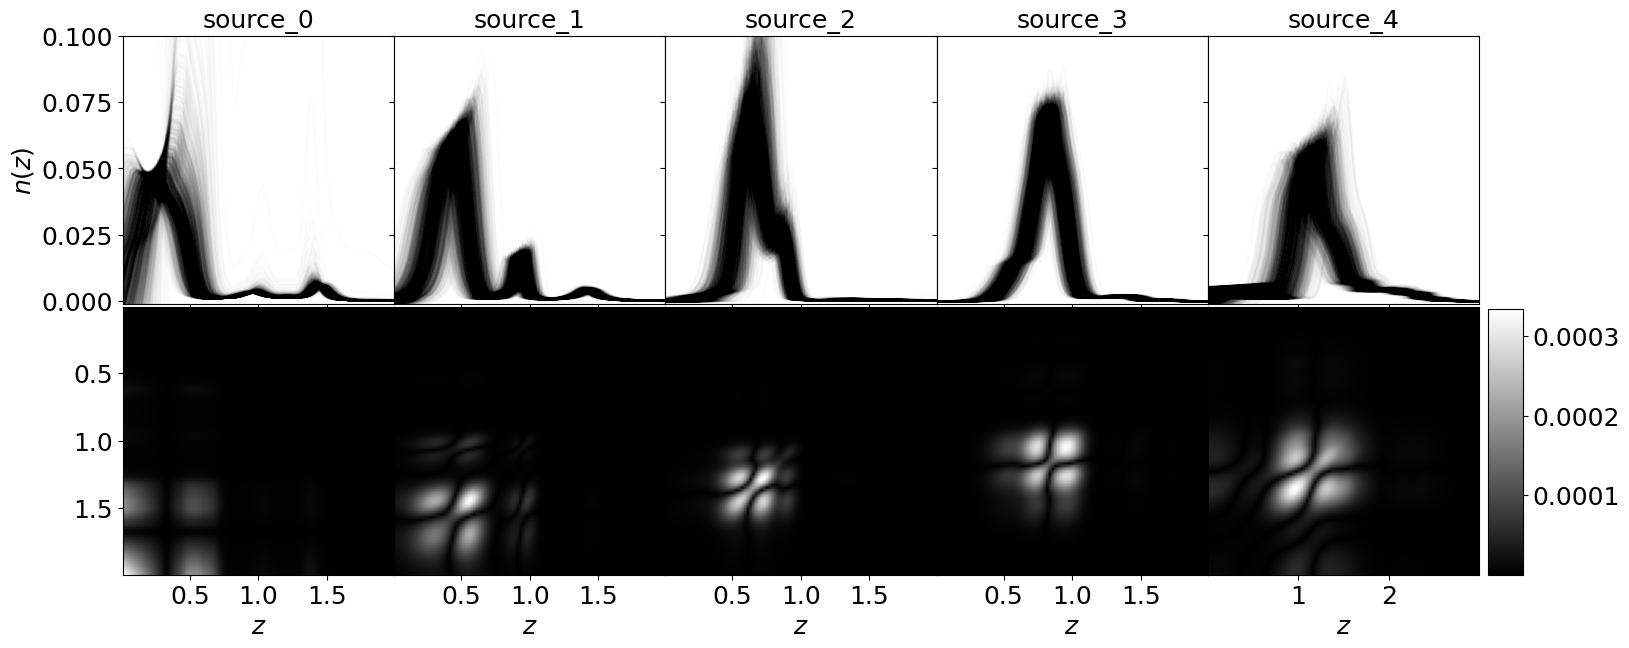

In [28]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

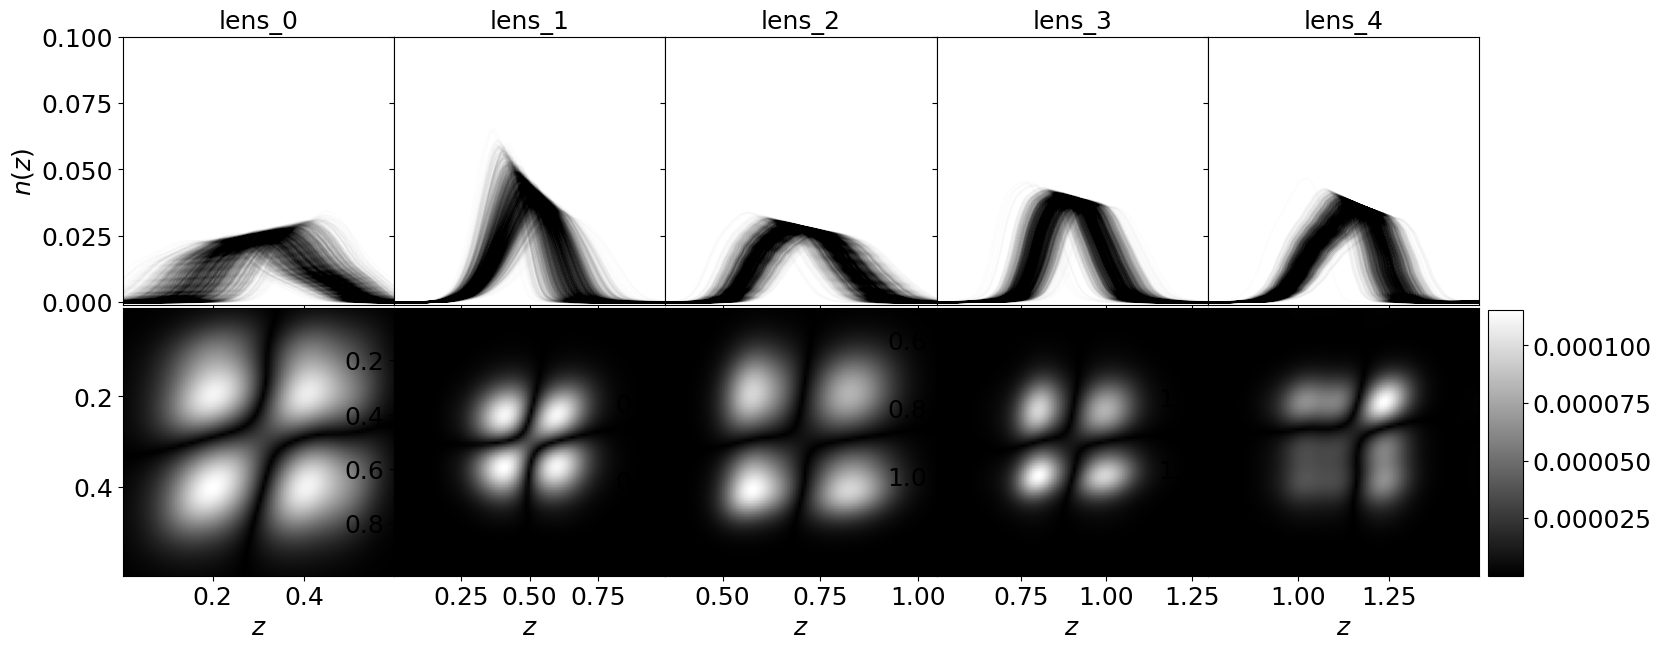

In [29]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

In [30]:
SnWs_var_comp = {}
_SnWs_var_comp = {}
SnWs_skew_comp = {}
_SnWs_skew_comp = {}
SnWs_kurt_comp = {}
_SnWs_kurt_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        shifted_nzs_i = SnWs_nzs[tracer_name][1].T
        _shifted_nzs_i = _SnWs_nzs[tracer_name][1].T
        nzs = model_obj.nzs
        zs = model_obj.z
        cov = np.cov(shifted_nzs_i)
        _cov = np.cov(_shifted_nzs_i)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        sk = scipy.stats.skew(shifted_nzs_i, axis=1)
        _sk = scipy.stats.skew(_shifted_nzs_i, axis=1)
        __sk = scipy.stats.skew(nzs, axis=0)
        ku = scipy.stats.kurtosis(shifted_nzs_i, axis=1)
        _ku = scipy.stats.kurtosis(_shifted_nzs_i, axis=1)
        __ku = scipy.stats.kurtosis(nzs)
        print(tracer_name, np.mean(errs), np.mean(_errs), np.mean(__errs))
        print(tracer_name, np.mean(sk), np.mean(_sk), np.mean(__sk))
        print(tracer_name, np.mean(ku), np.mean(_ku), np.mean(__ku))
        print("=====")
        SnWs_var_comp[tracer_name]   = [zs, (errs-__errs)/__errs]
        _SnWs_var_comp[tracer_name]  = [zs, (_errs-__errs)/__errs]
        SnWs_skew_comp[tracer_name]  = [zs, (sk-__sk)/__sk]
        _SnWs_skew_comp[tracer_name] = [zs, (_sk-__sk)/__sk]
        SnWs_kurt_comp[tracer_name]  = [zs, (ku-__ku)/__ku]
        _SnWs_kurt_comp[tracer_name] = [zs, (_ku-__ku)/__ku]

source_0 0.050162924749460686 0.05015063142787888 0.004203544467801479
source_0 -16.280962717562375 -16.284794243784667 1.089871935162711
source_0 1179.4744719582627 1180.0379582814228 2.976247856472152
=====
source_1 0.0056090923295636684 0.005609372469122059 0.005915508482667201
source_1 2.0453576571101295 2.0453673064081217 1.951176083612043
source_1 33.007774994059766 33.01418808194455 11.418885104639767
=====
source_2 0.005291391584791197 0.005291152134190445 0.0038540940899966436
source_2 2.357128289388658 2.3574100468751826 3.1801783128477465
source_2 24.423691895772095 24.431398773569516 52.538439103022085
=====
source_3 0.00381391925083479 0.0038140557054494153 0.003826968983939829
source_3 2.5140477451517156 2.5141937635149 4.181483337161585
source_3 29.76034630374143 29.768740605905826 67.10002905978006
=====
source_4 0.00534321358086372 0.00534326059460903 0.00394747346337585
source_4 1.1770771440389722 1.1764551728470274 3.283442142074541
source_4 6.2853205891866075 6.2826

In [31]:
#SnWs_Ds = {}
#for tracer_name in SnWs_nzs.keys():
#    model_obj = SnWs_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = SnWs_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    SnWs_Ds[tracer_name] = np.abs(D)

## GP

In [32]:
gp_priors = nzp.PriorSacc(ss_qp,
                            model="GP",
                            compute_crosscorrs=crosscorrs_method,
                            n=5)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [33]:
mean, cov, chol = gp_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(chol)
plt.colorbar()

TypeError: 'NoneType' object is not iterable

In [ ]:
labels = [
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 0}" for q in gp_priors.model_objs['source_0'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 1}" for q in gp_priors.model_objs['source_1'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 2}" for q in gp_priors.model_objs['source_2'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 3}" for q in gp_priors.model_objs['source_3'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 4}" for q in gp_priors.model_objs['source_4'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 0}" for q in gp_priors.model_objs['lens_0'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 1}" for q in gp_priors.model_objs['lens_1'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 2}" for q in gp_priors.model_objs['lens_2'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 3}" for q in gp_priors.model_objs['lens_3'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 4}" for q in gp_priors.model_objs['lens_4'].q],
]
labels = np.array(labels).flatten()

In [ ]:
g = gp_priors.plot_prior(mode="1D", add_prior=True, labels=labels, nx=5, legend_ncol=2, lws=2, ls=['-','--'])
g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/gp_priors.pdf")

In [ ]:
gp_nzs = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = gp_priors.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    z = model_obj.z
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    W = W @ chol
    _nzs = np.array([nzp.linear_model(nz_mean, W, np.random.randn(5)) for i in range(2000)])
    gp_nzs[tracer_name] = [z, _nzs]

In [ ]:
_gp_nzs = {}
for i in range(2000):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = gp_priors.model_objs[tracer_name]
        nz_mean = model_obj.nz_mean
        param_names = model_obj.get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = model_obj.get_params().T[i]
        nq = params - model_obj.prior_mean
        W = model_obj.funcs
        nz = nzp.linear_model(nz_mean, W, nq)
        z = model_obj.z
        if i == 0:
            _gp_nzs[tracer_name] = [z, nz]
        else:
            _gp_nzs[tracer_name] = [z, np.vstack([gp_nzs[tracer_name][1], nz])]

In [ ]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(gp_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(gp_nzs, plot_tracers)

In [ ]:
model_objs = gp_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    W = W @ chol
    file_name = f"gp_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_gp_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, W=W)


In [ ]:
model_objs = gp_priors.model_objs
figure, axis = plt.subplots(2, 5, figsize=(5*4,8))
figure.subplots_adjust(wspace=0, hspace=0.01)
lens_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
for i, t in enumerate(lens_tracers):
    model_obj = model_objs[t]
    W = model_obj.funcs
    _, _, chol = model_obj.get_prior()
    W = W @ chol
    axis[0, i].plot(model_obj.z, W)
    axis[0, i].set_title(t, y=0.9)
    axis[0, i].set_ylim([-0.02, 0.02])
    if i > 0:
        axis[0, i].set_yticklabels([])
source_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
for i, t in enumerate(source_tracers):
    model_obj = model_objs[t]
    W = model_obj.funcs
    _, _, chol = model_obj.get_prior()
    W = W @ chol
    axis[1, i].plot(model_obj.z, W)
    axis[1, i].set_title(t, y=0.9)
    axis[1, i].set_ylim([-0.02, 0.02])
    if i > 0:
        axis[1, i].set_yticklabels([])

labels = ["k=1", "k=2", "k=3", "k=4", "k=5"]
figure.legend(lines, labels, ncol=5, loc='upper center', bbox_to_anchor=(0.5, 0.95))
figure.text(0.5, 0.04, 'Redshift', ha='center')
figure.text(0.08, 0.5, 'Columns of Wiener filter', va='center', rotation='vertical')

In [ ]:
gp_var_comp = {}
_gp_var_comp = {}
gp_skew_comp = {}
_gp_skew_comp = {}
gp_kurt_comp = {}
_gp_kurt_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = gp_priors.model_objs[tracer_name]
        shifted_nzs_i = gp_nzs[tracer_name][1].T
        _shifted_nzs_i = _gp_nzs[tracer_name][1].T
        nzs = model_obj.nzs
        zs = model_obj.z
        cov = np.cov(shifted_nzs_i)
        _cov = np.cov(_shifted_nzs_i)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        sk = scipy.stats.skew(shifted_nzs_i, axis=1)
        _sk = scipy.stats.skew(_shifted_nzs_i, axis=1)
        __sk = scipy.stats.skew(nzs, axis=0)
        ku = scipy.stats.kurtosis(shifted_nzs_i, axis=1)
        _ku = scipy.stats.kurtosis(_shifted_nzs_i, axis=1)
        __ku = scipy.stats.kurtosis(nzs)
        print(tracer_name, np.mean(errs), np.mean(_errs), np.mean(__errs))
        print(tracer_name, np.mean(sk), np.mean(_sk), np.mean(__sk))
        print(tracer_name, np.mean(ku), np.mean(_ku), np.mean(__ku))
        print("=====")
        gp_var_comp[tracer_name]   = [zs, (errs-__errs)/__errs]
        _gp_var_comp[tracer_name]  = [zs, (_errs-__errs)/__errs]
        gp_skew_comp[tracer_name]  = [zs, (sk-__sk)/__sk]
        _gp_skew_comp[tracer_name] = [zs, (_sk-__sk)/__sk]
        gp_kurt_comp[tracer_name]  = [zs, (ku-__ku)/__ku]
        _gp_kurt_comp[tracer_name] = [zs, (_ku-__ku)/__ku]

# PCA

In [ ]:
PCA_priors = nzp.PriorSacc(ss_qp,
                            model="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            n=5)

In [ ]:
mean, cov, chol = PCA_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(np.sqrt(abs(cov)))
plt.colorbar()

In [ ]:
labels = [
    r"\alpha_{1}^{\rm source \, 0}",
    r"\alpha_{2}^{\rm source \, 0}",
    r"\alpha_{3}^{\rm source \, 0}",
    r"\alpha_{4}^{\rm source \, 0}",
    r"\alpha_{5}^{\rm source \, 0}",
    r"\alpha_{1}^{\rm source \, 1}",
    r"\alpha_{2}^{\rm source \, 1}",
    r"\alpha_{3}^{\rm source \, 1}",
    r"\alpha_{4}^{\rm source \, 1}",
    r"\alpha_{5}^{\rm source \, 1}",
    r"\alpha_{1}^{\rm source \, 2}",
    r"\alpha_{2}^{\rm source \, 2}",
    r"\alpha_{3}^{\rm source \, 2}",
    r"\alpha_{4}^{\rm source \, 2}",
    r"\alpha_{5}^{\rm source \, 2}",
    r"\alpha_{1}^{\rm source \, 3}",
    r"\alpha_{2}^{\rm source \, 3}",
    r"\alpha_{3}^{\rm source \, 3}",
    r"\alpha_{4}^{\rm source \, 3}",
    r"\alpha_{5}^{\rm source \, 3}",
    r"\alpha_{1}^{\rm source \, 4}",
    r"\alpha_{2}^{\rm source \, 4}",
    r"\alpha_{3}^{\rm source \, 4}",
    r"\alpha_{4}^{\rm source \, 4}",
    r"\alpha_{5}^{\rm source \, 4}",
    r"\alpha_{1}^{\rm lens \, 0}",
    r"\alpha_{2}^{\rm lens \, 0}",
    r"\alpha_{3}^{\rm lens \, 0}",
    r"\alpha_{4}^{\rm lens \, 0}",
    r"\alpha_{5}^{\rm lens \, 0}",
    r"\alpha_{1}^{\rm lens \, 1}",
    r"\alpha_{2}^{\rm lens \, 1}",
    r"\alpha_{3}^{\rm lens \, 1}",
    r"\alpha_{4}^{\rm lens \, 1}",
    r"\alpha_{5}^{\rm lens \, 1}",
    r"\alpha_{1}^{\rm lens \, 2}",
    r"\alpha_{2}^{\rm lens \, 2}",
    r"\alpha_{3}^{\rm lens \, 2}",
    r"\alpha_{4}^{\rm lens \, 2}",
    r"\alpha_{5}^{\rm lens \, 2}",
    r"\alpha_{1}^{\rm lens \, 3}",
    r"\alpha_{2}^{\rm lens \, 3}",
    r"\alpha_{3}^{\rm lens \, 3}",
    r"\alpha_{4}^{\rm lens \, 3}",
    r"\alpha_{5}^{\rm lens \, 3}",
    r"\alpha_{1}^{\rm lens \, 4}",
    r"\alpha_{2}^{\rm lens \, 4}",
    r"\alpha_{3}^{\rm lens \, 4}",
    r"\alpha_{4}^{\rm lens \, 4}",
    r"\alpha_{5}^{\rm lens \, 4}",
]

In [ ]:
g = PCA_priors.plot_prior(mode="1D", add_prior=True, nx=5, labels=labels, legend_ncol=2, lws=2, ls=['-','--'])
g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/pca_priors.pdf")

In [ ]:
pca_nzs = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = PCA_priors.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    z = model_obj.z
    W = model_obj.funcs
    W = W @ chol
    _nzs = np.array([nzp.linear_model(nz_mean, W, np.random.randn(5)) for i in range(2000)])
    pca_nzs[tracer_name] = [z, _nzs]

In [ ]:
_pca_nzs = {}
for i in range(2000):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = PCA_priors.model_objs[tracer_name]
        z = model_obj.z
        nz_mean = model_obj.nz_mean
        params = model_obj.get_params().T[i]
        W = model_obj.funcs
        nz = nzp.linear_model(nz_mean, W, params)
        if i == 0:
            _pca_nzs[tracer_name] = [z, nz]
        else:

            _pca_nzs[tracer_name] = [z, np.vstack([pca_nzs[tracer_name][1], nz])]

In [ ]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(pca_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(pca_nzs, plot_tracers)

In [ ]:
model_objs = PCA_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    W = W @ chol
    file_name = f"PCA_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_PCA_{}_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, W=W)

In [ ]:
model_objs = PCA_priors.model_objs
figure, axis = plt.subplots(2, 5, figsize=(5*4,8))
figure.subplots_adjust(wspace=0, hspace=0.01)
lens_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
for i, t in enumerate(lens_tracers):
    model_obj = model_objs[t]
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    W = W @ chol
    lines = axis[0, i].plot(model_obj.z, W)
    axis[0, i].set_title(t, y=0.9)
    axis[0, i].set_ylim([-0.02, 0.02])
    if i > 0:
        axis[0, i].set_yticklabels([])
source_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
for i, t in enumerate(source_tracers):
    model_obj = model_objs[t]
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    W = W @ chol
    axis[1, i].plot(model_obj.z, W)
    axis[1, i].set_title(t, y=0.9)
    axis[1, i].set_ylim([-0.02, 0.02])
    if i > 0:
        axis[1, i].set_yticklabels([])

labels = ["k=1", "k=2", "k=3", "k=4", "k=5"]
figure.legend(lines, labels, ncol=5, loc='upper center', bbox_to_anchor=(0.5, 0.95))
figure.text(0.5, 0.04, 'Redshift', ha='center')
figure.text(0.08, 0.5, 'Eigenvectors', va='center', rotation='vertical')


In [ ]:
pca_var_comp = {}
_pca_var_comp = {}
pca_skew_comp = {}
_pca_skew_comp = {}
pca_kurt_comp = {}
_pca_kurt_comp = {}
for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = PCA_priors.model_objs[tracer_name]
        shifted_nzs_i = pca_nzs[tracer_name][1].T
        _shifted_nzs_i = _pca_nzs[tracer_name][1].T
        nzs = model_obj.nzs
        zs = model_obj.z
        cov = np.cov(shifted_nzs_i)
        _cov = np.cov(_shifted_nzs_i)
        __cov = model_obj.nz_cov
        errs = np.sqrt(np.diag(cov))
        _errs = np.sqrt(np.diag(_cov))
        __errs = np.sqrt(np.diag(__cov))
        sk = scipy.stats.skew(shifted_nzs_i, axis=1)
        _sk = scipy.stats.skew(_shifted_nzs_i, axis=1)
        __sk = scipy.stats.skew(nzs, axis=0)
        ku = scipy.stats.kurtosis(shifted_nzs_i, axis=1)
        _ku = scipy.stats.kurtosis(_shifted_nzs_i, axis=1)
        __ku = scipy.stats.kurtosis(nzs)
        print(tracer_name, np.mean(errs), np.mean(_errs), np.mean(__errs))
        print(tracer_name, np.mean(sk), np.mean(_sk), np.mean(__sk))
        print(tracer_name, np.mean(ku), np.mean(_ku), np.mean(__ku))
        print("=====")
        pca_var_comp[tracer_name]   = [zs, (errs-__errs)/__errs]
        _pca_var_comp[tracer_name]  = [zs, (_errs-__errs)/__errs]
        pca_skew_comp[tracer_name]  = [zs, (sk-__sk)/__sk]
        _pca_skew_comp[tracer_name] = [zs, (_sk-__sk)/__sk]
        pca_kurt_comp[tracer_name]  = [zs, (ku-__ku)/__ku]
        _pca_kurt_comp[tracer_name] = [zs, (_ku-__ku)/__ku]

In [ ]:
#pca_Ds = {}
#for tracer_name in pca_nzs.keys():
#    model_obj = PCA_priors.model_objs[tracer_name]
#    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
#    nzs = pca_nzs[tracer_name][1]
#    mu_2 = np.mean(nzs, axis=0)
#    K_2 = np.cov(nzs.T)
#    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
#    pca_Ds[tracer_name] = np.abs(D)

# Comparison

In [ ]:
import statistics as stats
def make_var_plots(vars, _vars, tracer_list, labels):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*7,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    colors = ['blue', 'orange', 'green', 'red']
    for i, key in enumerate(tracer_list):
        for j, var in enumerate(vars):
            zs, _var = var[key]
            zs, __var = _vars[j][key]
            m_err = round(stats.mean(np.abs(_var)), 3)
            _m_err = round(stats.mean(np.abs(__var)), 3)
            axis[i].plot(zs, np.abs(_var), color=colors[j], alpha=0.5, label=f"{labels[j]} - Gaussian {m_err}")
            axis[i].plot(zs, np.abs(__var), color=colors[j], alpha=0.5, linestyle='--', label=f"{labels[j]} - True {_m_err}")
        axis[i].plot(zs, np.zeros_like(zs), 'k--')
        axis[i].set_ylim([0.001, 100])
        #axis[i].set_yscale('symlog', linthresh=0.01, linscale=1)
        axis[i].set_yscale('log')
        axis[i].set_title(key)
        axis[i].set_xlabel('z')
        axis[i].legend(ncol=2)
        if i == 0:
            axis[i].set_ylabel('Relative error')
        else:
            axis[i].set_yticklabels([])
    plt.show()
    return figure

def make_var_plots2(vars, tracer_list, labels):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*4,4))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        print(key)
        for j, var in enumerate(vars):
            zs, _var = var[key]
            axis[i].fill_between(zs, np.zeros_like(zs), np.abs(_var), label=labels[j], alpha=0.5)
            print(labels[j], round(np.mean(np.abs(_var)), 3))
        print("====")
        axis[i].plot(zs, np.zeros_like(zs), 'k--')
        axis[i].set_ylim([0.001, 10])
        axis[i].set_yscale('log')
        axis[i].set_title(key)
        axis[i].set_xlabel('z')
        axis[i].legend()
        if i == 0:
            axis[i].set_ylabel('Relative error')
        else:
            axis[i].set_yticklabels([])
    plt.show()
    return figure

In [ ]:
labels = ['Shifts', 'Shifts & Widths', 'PCA', 'GP',]

In [ ]:
vars = [shifts_var_comp, SnWs_var_comp, pca_var_comp, gp_var_comp]
_vars = [_shifts_var_comp, _SnWs_var_comp, _pca_var_comp, _gp_var_comp]

skews = [shifts_skew_comp, SnWs_skew_comp, pca_skew_comp, gp_skew_comp]
_skews = [_shifts_skew_comp, _SnWs_skew_comp, _pca_skew_comp, _gp_skew_comp]

kurts = [shifts_kurt_comp, SnWs_kurt_comp, pca_kurt_comp, gp_kurt_comp]
_kurts = [_shifts_kurt_comp, _SnWs_kurt_comp, _pca_kurt_comp, _gp_kurt_comp]

In [ ]:
source_traces = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
lens_traces = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
shifts_mean_var_comp = np.zeros(2)
SnWs_mean_var_comp = np.zeros(2)
pca_mean_var_comp = np.zeros(2)
gp_mean_var_comp = np.zeros(2)
_shifts_mean_var_comp = np.zeros(2)
_SnWs_mean_var_comp = np.zeros(2)
_pca_mean_var_comp = np.zeros(2)
_gp_mean_var_comp = np.zeros(2)
for tracer_name in source_traces:
    shifts_mean_var_comp[0] += np.mean(shifts_var_comp[tracer_name][1])
    SnWs_mean_var_comp[0] += np.mean(SnWs_var_comp[tracer_name][1])
    pca_mean_var_comp[0] += np.mean(pca_var_comp[tracer_name][1])
    gp_mean_var_comp[0] += np.mean(gp_var_comp[tracer_name][1])
    _shifts_mean_var_comp[0] +=  np.mean(_shifts_var_comp[tracer_name][1])
    _SnWs_mean_var_comp[0] += np.mean(_SnWs_var_comp[tracer_name][1])
    _pca_mean_var_comp[0] += np.mean(_pca_var_comp[tracer_name][1])
    _gp_mean_var_comp[0] += np.mean(_gp_var_comp[tracer_name][1])
for tracer_name in lens_traces:
    shifts_mean_var_comp[1] += np.mean(shifts_var_comp[tracer_name][1])
    SnWs_mean_var_comp[1] += np.mean(SnWs_var_comp[tracer_name][1])
    pca_mean_var_comp[1] += np.mean(pca_var_comp[tracer_name][1])
    gp_mean_var_comp[1] += np.mean(gp_var_comp[tracer_name][1])
    _shifts_mean_var_comp[1] +=  np.mean(_shifts_var_comp[tracer_name][1])
    _SnWs_mean_var_comp[1] += np.mean(_SnWs_var_comp[tracer_name][1])
    _pca_mean_var_comp[1] += np.mean(_pca_var_comp[tracer_name][1])
    _gp_mean_var_comp[1] += np.mean(_gp_var_comp[tracer_name][1])

shifts_mean_var_comp /= len(source_traces)
SnWs_mean_var_comp /= len(source_traces)
pca_mean_var_comp /= len(source_traces)
gp_mean_var_comp /= len(source_traces)
_shifts_mean_var_comp /= len(source_traces)
_SnWs_mean_var_comp /= len(source_traces)
_pca_mean_var_comp /= len(source_traces)
_gp_mean_var_comp /= len(source_traces)


In [ ]:
g = make_var_plots(vars, _vars, ['source_0', 'source_1', 'source_2', 'source_3', 'source_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_validation.pdf", bbox_inches='tight')

In [ ]:
make_var_plots(vars, _vars, ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/lens_validation.pdf", bbox_inches='tight')

In [ ]:
g = make_var_plots(skews, _skews, ['source_0', 'source_1', 'source_2', 'source_3', 'source_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_validation.pdf", bbox_inches='tight')

In [ ]:
make_var_plots(skews, _skews, ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/lens_validation.pdf", bbox_inches='tight')

In [ ]:
g = make_var_plots(kurts, _kurts, ['source_0', 'source_1', 'source_2', 'source_3', 'source_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_validation.pdf", bbox_inches='tight')

In [ ]:
make_var_plots(kurts, _kurts, ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'], labels)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/lens_validation.pdf", bbox_inches='tight')

In [ ]:
def make_nzs_comp_plot(methods, tracer):
    n_tracers = len(methods)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(methods):
        method = methods[key]
        tomo = method[tracer]
        if len(tomo) == 2:
            nzs = tomo[1][:50].T
            zs = tomo[0]
        else:
            nzs = tomo['photo_hists'].T[:50].T
            zs = tomo['znodes']
        norms = np.sum(nzs, axis=0)
        axis[0,i].plot(zs, nzs/norms, 'k-', alpha=0.1)
        cov = np.cov(nzs)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.001, 0.1])
        axis[0,i].set_title(key, y=0.9)
        if i == 0:
            axis[0,i].set_ylabel(r'$n_{\rm source \, 0}(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()
    return figure

In [ ]:
g = make_nzs_comp_plot({'Data': tomos, 'Shifts':shifted_nzs, 'Shifts & Widths':SnWs_nzs, 'PCA':pca_nzs, 'GP':gp_nzs}, 'source_0')
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_0_validation.pdf", bbox_inches='tight')

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(2*4,4))
figure.subplots_adjust(wspace=0, hspace=0.01)

axis[0].plot([1], np.abs(shifts_mean_var_comp[1]), 'o-', color="C0", label="Shifts")
axis[0].plot([2], np.abs(SnWs_mean_var_comp[1]), 'ro-', color="C1", label="Shifts & Widths")
axis[0].plot([5], np.abs(pca_mean_var_comp[1]), 'go-', label="PCA")
axis[0].plot([5], np.abs(gp_mean_var_comp[1]), 'ro-', label="GP")
#axis[0].set_xticks(np.arange(1, 6+1))
axis[0].set_xticklabels(['1', '2', '5'])
axis[0].set_xlabel('n')
axis[0].set_ylabel('Mean relative error')
axis[0].set_title('Lens')
axis[0].legend()
axis[0].set_yscale('log')
axis[0].set_ylim([0.0, 5])
axis[0].grid(True)

axis[1].plot([1], np.abs(shifts_mean_var_comp[0]), 'o-', color="C0", label="Shifts")
axis[1].plot([2], np.abs(SnWs_mean_var_comp[0]), 'ro-', color="C1", label="Shifts & Widths")
axis[1].plot([5], np.abs(pca_mean_var_comp[0]), 'go-', label="PCA")
axis[1].plot([5], np.abs(gp_mean_var_comp[0]), 'ro-', label="GP")
#axis[1].set_xticks(np.arange(1, 6+1))
axis[1].set_xticklabels(['1', '2', '5'])
axis[1].set_xlabel('n')
axis[1].set_title('Sources')
#axis[1].legend()
axis[1].set_yscale('log')
axis[1].set_ylim([0.0, 5])
axis[1].set_yticklabels([])
axis[1].grid(True)
plt.show()